In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.__version__

import sys
from multiprocessing import Pool
import h5py

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [3]:
# trainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_train_corners_lhd.hdf5')
# amp_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_corners_lhd.hdf5'
# phase_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_corners_lhd.hdf5'
# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_corners_lhd.hdf5'

# trainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_train_lhd_uncsamp.hdf5')
# amp_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# phase_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp.hdf5'

# trainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_train_lhd_uncsamp_rand.hdf5')
# amp_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
# phase_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp_rand.hdf5'

trainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_train_lhd_uncsamp_rand_uniformxi.hdf5')
amp_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp_rand_uniformxi.hdf5'
phase_gp_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp_rand_uniformxi.hdf5'
nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp_rand_uniformxi.hdf5'

# Manually specify locations of interpolating nodes
namp = 40
nphase = 39
h = trainset[0]
amp_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), namp)
phase_mfs = np.logspace(np.log10(h.x[0]), np.log10(h.x[-1]), nphase+1)
phase_mfs = np.delete(phase_mfs, 0)

print trainset.parameters().shape
print len(amp_mfs), amp_mfs
print len(phase_mfs), phase_mfs

(2159, 5)
40 [0.00021    0.00024373 0.00028288 0.00032831 0.00038104 0.00044225
 0.00051328 0.00059572 0.00069141 0.00080246 0.00093135 0.00108094
 0.00125455 0.00145606 0.00168993 0.00196136 0.00227639 0.00264202
 0.00306637 0.00355889 0.00413051 0.00479394 0.00556393 0.0064576
 0.0074948  0.0086986  0.01009575 0.0117173  0.01359931 0.0157836
 0.01831873 0.02126104 0.02467594 0.02863933 0.03323931 0.03857814
 0.04477447 0.05196604 0.06031271 0.07      ]
39 [0.00024373 0.00028288 0.00032831 0.00038104 0.00044225 0.00051328
 0.00059572 0.00069141 0.00080246 0.00093135 0.00108094 0.00125455
 0.00145606 0.00168993 0.00196136 0.00227639 0.00264202 0.00306637
 0.00355889 0.00413051 0.00479394 0.00556393 0.0064576  0.0074948
 0.0086986  0.01009575 0.0117173  0.01359931 0.0157836  0.01831873
 0.02126104 0.02467594 0.02863933 0.03323931 0.03857814 0.04477447
 0.05196604 0.06031271 0.07      ]


In [4]:
# Write the nodes hdf5 file
f = h5py.File(nodes_filename)
f['amp_mfs'] = amp_mfs
f['phase_mfs'] = phase_mfs
f.close()

2159


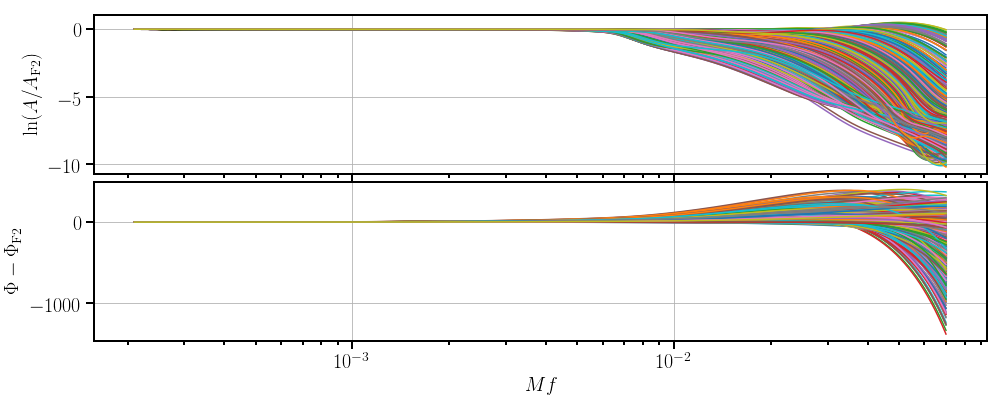

In [5]:
print len(trainset)

fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [6]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(amp_mfs)):
    mf = amp_mfs[j]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(phase_mfs)):
    mf = phase_mfs[j]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)

In [7]:
# Do coordinate transformation
def lam_of_xi(xi, a=100):
    return a*(10**xi - 1)

def xi_of_lam(lam, a=100):
    return np.log10(lam/a + 1)

# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

lam1s = params_ts[:, 3]
lam2s = params_ts[:, 4]

xi1s = xi_of_lam(lam1s)
xi2s = xi_of_lam(lam2s)

params_ts[:, 3] = xi1s
params_ts[:, 4] = xi2s

In [8]:
ximin = xi_of_lam(0)
ximax = xi_of_lam(5000)
print ximin, ximax

0.0 1.7075701760979363


In [9]:
def generate_amp_gp_from_data(i):
    print i,
    ximin = xi_of_lam(0)
    ximax = xi_of_lam(5000)
    limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])
    kernel_type = 'matern52'
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    return damp_gp

# Keep 1 core free so your computer is still usable
p = Pool(processes=7)
idx = range(len(damp_ts_list))
# Return a list of outputs (in the same order as the list of inputs)
damp_gp_list = p.map(generate_amp_gp_from_data, idx)

/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-5.28931562e-03,  2.68287799e-03,  5.22918451e-03, -2.21301603e+02,
        1.31839798e-02, -9.46970691e+01,  1.06898115e-03]), 'nit': 17, 'funcalls': 62}
  " state: %s" % convergence_dict)


In [10]:
[gp.kernel_ for gp in damp_gp_list]

[0.000704**2 * Matern(length_scale=[2.12, 2.65, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=2.41e-16),
 0.00077**2 * Matern(length_scale=[2.14, 2.64, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=2.99e-16),
 0.000889**2 * Matern(length_scale=[2.16, 2.63, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=4.17e-16),
 0.00103**2 * Matern(length_scale=[2.19, 2.62, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=5.88e-16),
 0.00119**2 * Matern(length_scale=[2.22, 2.61, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=8.26e-16),
 0.00143**2 * Matern(length_scale=[2.27, 2.61, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=1.16e-15),
 0.00166**2 * Matern(length_scale=[2.28, 2.6, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=1.65e-15),
 0.0019**2 * Matern(length_scale=[2.32, 2.6, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=2.33e-15),
 0.00223**2 * Matern(length_scale=[2.35, 2.6, 4, 6.83, 6.83], nu=2.5) + WhiteKernel(noise_level=3.31e-15),
 0.00264**2 * Matern(length_sc

In [ ]:
# #limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
# limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])

# kernel_type = 'matern52'

# damp_gp_list = []
# for i in range(len(damp_ts_list)):
#     print i
#     points = params_ts
#     data = damp_ts_list[i]
#     hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
#     damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
#                                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
#     print gpr.get_hyperparameters(damp_gp)
#     damp_gp_list.append(damp_gp)

In [11]:
def generate_phase_gp_from_data(i):
    sys.stderr.write('{}'.format(i))
    ximin = xi_of_lam(0)
    ximax = xi_of_lam(5000)
    limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])
    kernel_type = 'matern52'
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(
        data, limits, 
        sigma_f_factor=[0.1, 10.0], 
        length_scale_factor=[0.05, 10.0], 
        sigma_n_factor=[1.0e-5, 5.0e-2])
    #print hyper_limits
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    return dphase_gp


p = Pool(processes=7)
idx = range(len(dphase_ts_list))
dphase_gp_list = p.map(generate_phase_gp_from_data, idx)

12/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-3.30070257e-02,  1.22606133e-01,  1.19180928e-01, -1.34697141e+02,
       -1.49556218e-01, -7.08193866e-04,  9.82951865e-02]), 'nit': 31, 'funcalls': 81}
  " state: %s" % convergence_dict)
10/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.99930573e-03, -1.29381352e-03,  3.32795118e-03, -1.34082484e+02,
        2.23683417e-03,  7.44696460e-03,  8.84735921e-02]), 'nit': 33, 'funcalls': 97}
  " state: %s" % convergence_dict)
4/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wit

In [12]:
[gp.kernel_ for gp in dphase_gp_list]

[0.0996**2 * Matern(length_scale=[4.45, 5.43, 9.44, 12.1, 16.4], nu=2.5) + WhiteKernel(noise_level=1.05e-10),
 0.591**2 * Matern(length_scale=[4.53, 5.63, 10, 12.5, 14.4], nu=2.5) + WhiteKernel(noise_level=7.83e-10),
 1.57**2 * Matern(length_scale=[4.62, 5.76, 10, 12.6, 15], nu=2.5) + WhiteKernel(noise_level=1.38e-09),
 3.08**2 * Matern(length_scale=[4.65, 5.82, 10, 12.6, 15.2], nu=2.5) + WhiteKernel(noise_level=1.02e-09),
 5.21**2 * Matern(length_scale=[4.66, 5.82, 10, 12.6, 15.3], nu=2.5) + WhiteKernel(noise_level=2.92e-11),
 8.05**2 * Matern(length_scale=[4.68, 5.81, 10, 12.7, 15.4], nu=2.5) + WhiteKernel(noise_level=7.24e-11),
 11.8**2 * Matern(length_scale=[4.69, 5.81, 10, 12.7, 15.4], nu=2.5) + WhiteKernel(noise_level=1.59e-10),
 16.5**2 * Matern(length_scale=[4.7, 5.8, 10, 12.7, 15.4], nu=2.5) + WhiteKernel(noise_level=3.21e-10),
 22.5**2 * Matern(length_scale=[4.7, 5.8, 10, 12.7, 15.4], nu=2.5) + WhiteKernel(noise_level=6.06e-10),
 29.8**2 * Matern(length_scale=[4.71, 5.79, 10,

In [ ]:
# #limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, 5000], [0, 5000]])
# limits = np.array([[1.0/3.0, 1.0], [-0.5, 0.5], [-0.5, 0.5], [0, ximax], [0, ximax]])

# kernel_type = 'matern52'
# #kernel_type = 'squaredexponential'

# dphase_gp_list = []
# for i in range(len(dphase_ts_list)):
#     print i
#     points = params_ts
#     data = dphase_ts_list[i]
#     hp0, hyper_limits = gpr.reasonable_hyperparameters_range(
#         data, limits, 
#         sigma_f_factor=[0.1, 10.0], 
#         length_scale_factor=[0.05, 10.0], 
#         sigma_n_factor=[1.0e-5, 5.0e-2])
#     print hyper_limits
#     dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
#                                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
    
#     print gpr.get_hyperparameters(dphase_gp)
#     dphase_gp_list.append(dphase_gp)

In [13]:
# Save GPR functions
gpr.save_gaussian_process_regression_list(amp_gp_filename, damp_gp_list, 'matern52')
gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'matern52')
# gpr.save_gaussian_process_regression_list(phase_gp_filename, dphase_gp_list, 'squaredexponential')

# Test GPSplineSurrogate class

In [14]:
# trainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/h_train_corners_lhd.hdf5')
# dtrainset = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_train_corners_lhd.hdf5')

testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/h_test2.hdf5')
dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_test2.hdf5')

[ 3.80943028e-01 -2.00598993e-01 -1.57797752e-01  3.30990910e+02
  2.52579575e+03]


Text(0.5,0,'$Mf$')

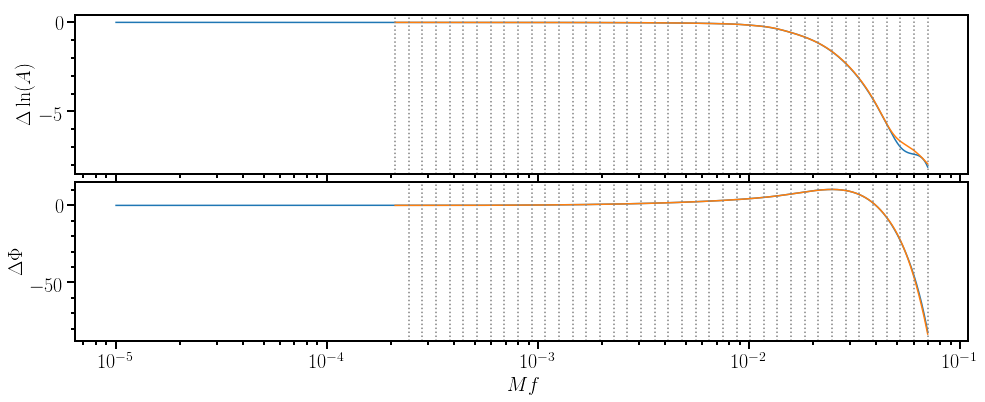

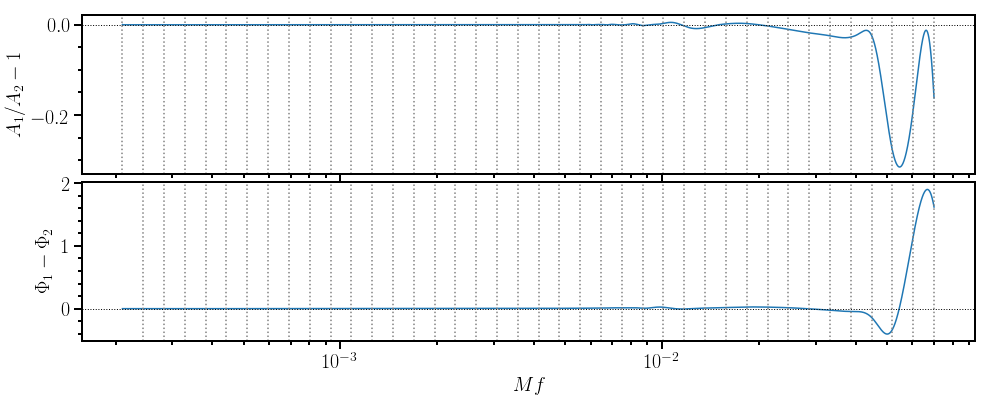

In [15]:
# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp_rand.hdf5'
# gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
# sur = surrogate.GPSplineSurrogate.load(
#     nodes_filename, gp_amp_filename, gp_phase_filename, 
#     order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp_rand_uniformxi.hdf5'
gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp_rand_uniformxi.hdf5'
gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp_rand_uniformxi.hdf5'
sur = surrogate.GPSplineSurrogate.load(
    nodes_filename, gp_amp_filename, gp_phase_filename, 
    order=3, npoints=10000, quad1=None, quad2=None, spin_spin=False)

# i = 1
# htest = trainset[i]
# dhtest = dtrainset[i]
# params = dtrainset.get_waveform(i, data='parameters')
# print params

i = 0
htest = testset_rand[i]
dhtest = dtestset_rand[i]
params = dtestset_rand.get_waveform(i, data='parameters')
print params

hsur = sur.geometric_waveform(params)
dhsur = sur.amp_phase_difference(params)

# Resample
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.01, 0.01)
# ax2.set_ylim(-1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
# ax1.set_ylim(-0.05, 0.05)
# ax2.set_ylim(-0.1, 0.1)
ax1.minorticks_on()
ax2.minorticks_on()
# ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
# ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

(<Figure size 1152x432 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x3322a6f90>,
  <matplotlib.axes._subplots.AxesSubplot at 0x3326efd10>))

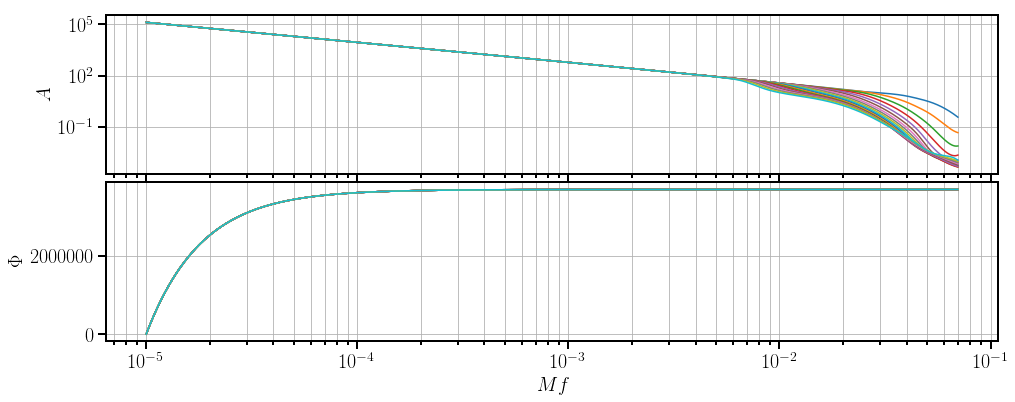

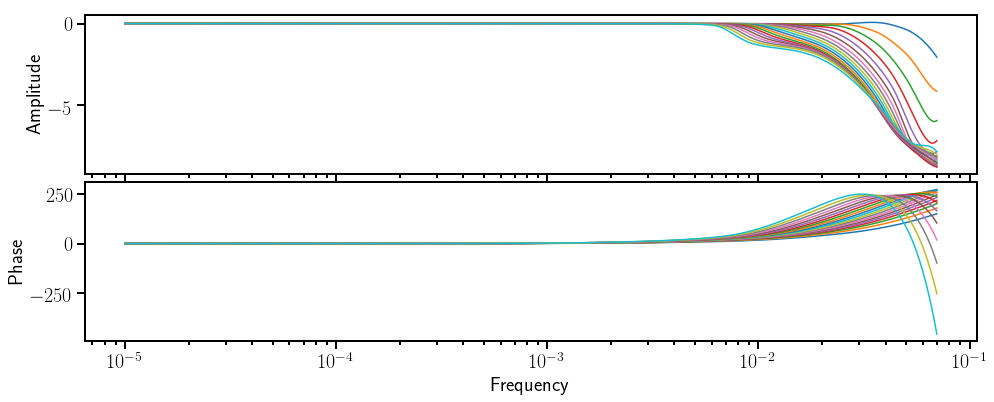

In [16]:
# Vary 1 parameter

q = 0.4
s1 = 0.4
s2 = 0.4
lambda1 = 200.
lambda2 = 200.

# q = 0.334
# s1 = 0.0
# s2 = 0.0
# lambda1 = 200.
# lambda2 = 200.

xis = np.linspace(xi_of_lam(0), xi_of_lam(5000), 20)
lam1s = lam_of_xi(xis)
ps = np.array([[q, s1, s2, lambda1, lambda2] for lambda1 in lam1s])

hs = [sur.geometric_waveform(p) for p in ps]
dhs = [sur.amp_phase_difference(p) for p in ps]

fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
ax1.set_yscale('log')
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')
ax1.grid(which='both')
ax2.grid(which='both')

wave.plot_waveforms_fd(dhs)